In [1]:
import scipy.signal as spsig
from scipy.stats import mode
import pytry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing
Create 2 dataframe. 1 with the raw output from the classifier (rawdata) and 1 with classified data (classifieddata)

Change np.load so allow_pickle=True

In [ ]:
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

Load data from testing into dataframe

In [ ]:
all_data = pd.DataFrame(pytry.read('Testing_Out'))
keys_goal_test = [k for k in all_data.keys() for v in all_data[k] if k.startswith('output_goal_test')]
keys_noplay_test = [k for k in all_data.keys() for v in all_data[k] if k.startswith('output_noplay_test')]
keys_aimless = [k for k in all_data.keys() for v in all_data[k] if k.startswith('output_aimless')]
keys_training = ['output_goal_train', 'output_noplay_train']
data2={}
for j in range(20):
    for k in keys_goal_test:
        a=all_data[k][j]['output']
        data2[k]=pd.Series([a])
    for k in keys_noplay_test:
        a=all_data[k][j]['output']
        data2[k]=pd.Series([a])
    for k in keys_aimless:
        a=all_data[k][j]['output']
        data2[k]=pd.Series([a])
    for k in keys_training:
        a=all_data[k][j+20]['output']
        data2[k]=pd.Series([a])
    if j==0:
        data2=pd.DataFrame(data2)
        data=data2
    else:
        data2=pd.DataFrame(data2)
        data=data.append(data2, ignore_index=True)
data

Restore np.load for future normal usage

In [ ]:
np.load = np_load_old

Reshape dataframe so that 1st column is clip titles and 2nd column is the output for that clip. <br>
Note: column 1 will be ordered such that the first 20 rows are the first clips from each experiment, the second 20 will be the second clips and so on.

In [ ]:
keys = [k for k in data.keys() for v in data[k]]
values = [v for k in data.keys() for v in data[k]]
data = pd.DataFrame.from_dict({'pattern':keys, 'output': values})
data=data.set_index('pattern')
data.to_pickle("rawdata")

Classification: <br> 
if value is greater than 0.3, change it to +1 (high engage) <br>
if value is less than 0.3 and greater than -0.3, change it to 0 (intermediate engage) <br>
if value is less than -0.3, change it to -1 (low engage) <br>

In [ ]:
for i in range(len(data)):
    for j in range(len(data.iloc[i]['output'])):
        if np.isclose(data.iloc[i]['output'][j], 1, atol=0.6):
            data.iloc[i]['output'][j] = 1
        elif np.isclose(data.iloc[i]['output'][j], 0, atol=0.3):
            data.iloc[i]['output'][j] = 0  
        else:
            data.iloc[i]['output'][j] = -1
data.to_pickle("classifieddata")

# Plot Raw Output

In [2]:
rawdata=pd.read_pickle("rawdata")

Now plot histograms of output values for all high engage training clips and all low engage training clips across all 20 experiments

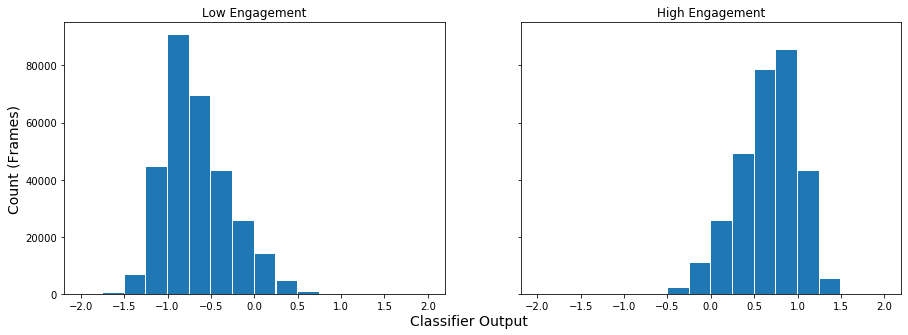

In [4]:
bins=np.arange(-2, 2 + 0.25, 0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hist(np.hstack(np.hstack(rawdata.iloc[1760:]['output'])), bins=bins, rwidth=0.95)
ax1.set_title('Low Engagement')
ax1.set_ylabel('Count (Frames)', fontsize=14)
ax2.hist(np.hstack(np.hstack(rawdata.iloc[1740:1760]['output'])), bins=bins, rwidth=0.95)
ax2.set_title('High Engagement')

#fig.suptitle('Output for Training Frames', fontsize=16)
fig.text(0.5, 0.04, 'Classifier Output', ha='center', fontsize=14)

fig.savefig('trainedout.png')

# Classification Median Filter
Classify each timepoint then apply median filter to get an approximation of the most common classification every 99 frames

In [6]:
classifieddata=pd.read_pickle("classifieddata")

Plot histogram of classification value after median filter for high and low engage training clips across all 20 experiments. <br>
Median calculated for every 99 frames

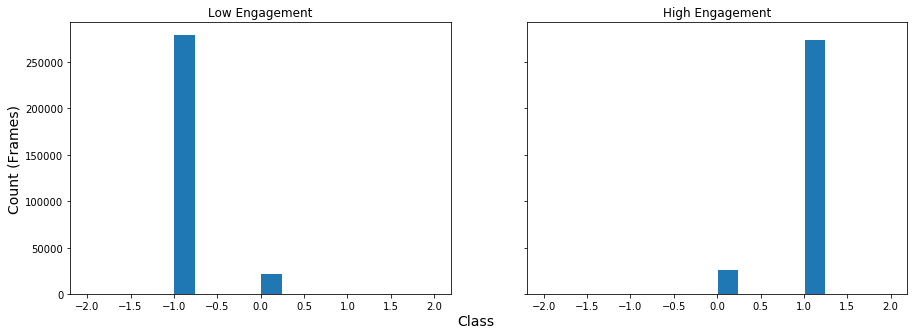

In [7]:
goal_med=spsig.medfilt((np.hstack(np.hstack(classifieddata.iloc[1740:1760]['output']))),99)
noplay_med=spsig.medfilt((np.hstack(np.hstack(classifieddata.iloc[1760:]['output']))),99)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hist(noplay_med, bins=bins, rwidth=0.95)
ax1.set_title('Low Engagement')
ax1.set_ylabel('Count (Frames)', fontsize=14)
ax2.hist(goal_med, bins=bins, rwidth=0.95)
ax2.set_title('High Engagement')

#fig.suptitle('Median Filter Classification of Training Frames', fontsize=16)
fig.text(0.5, 0.04, 'Class', ha='center', fontsize=14)
fig.savefig('trainedfilter.png')

Plot histograms of classification values for testing clips (high, intermediate and low engagement) in each experiment.

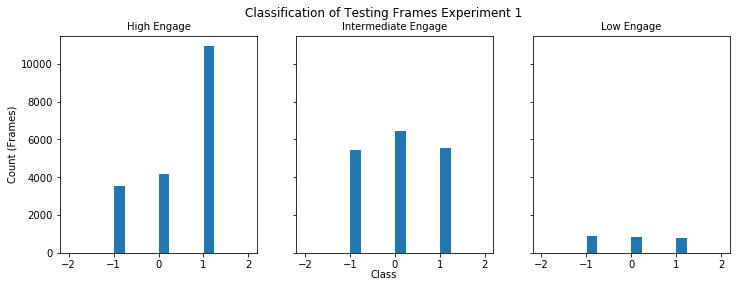

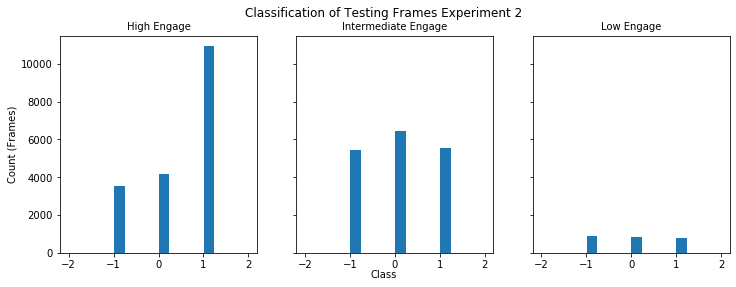

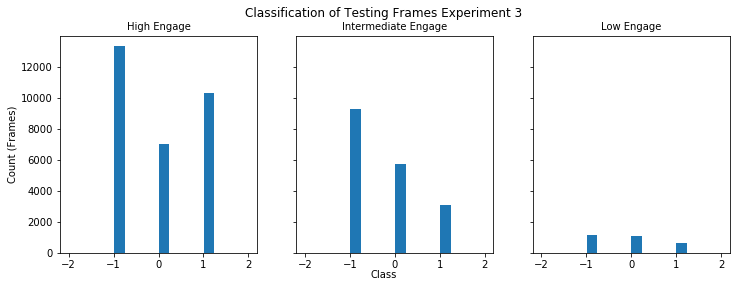

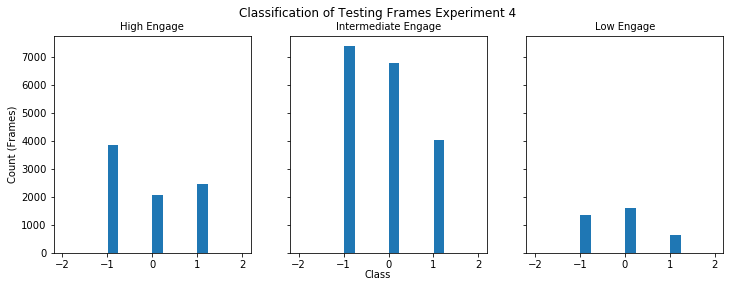

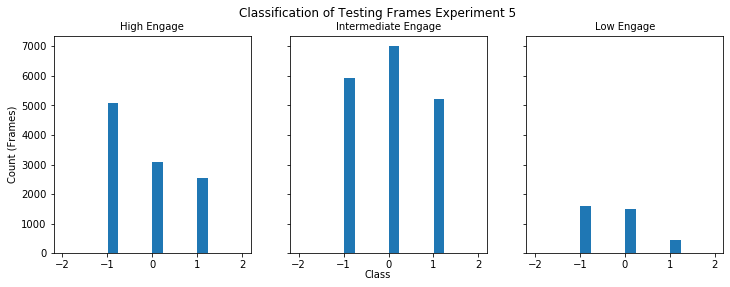

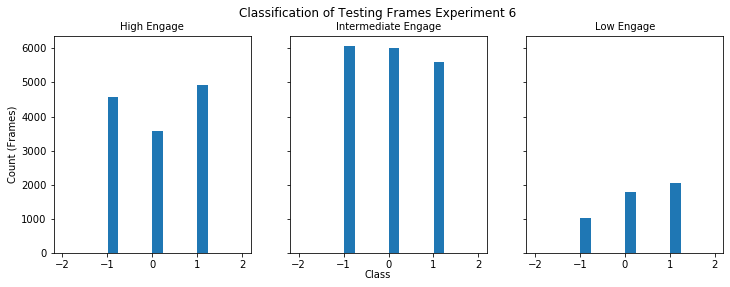

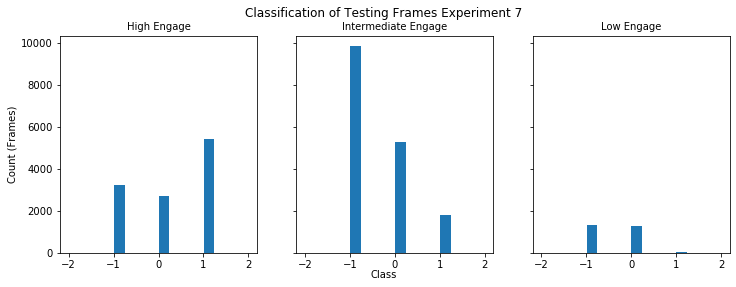

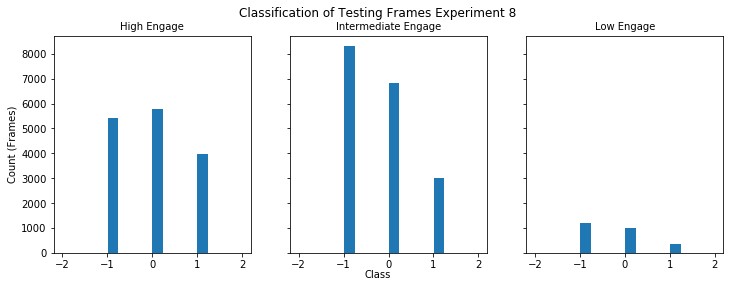

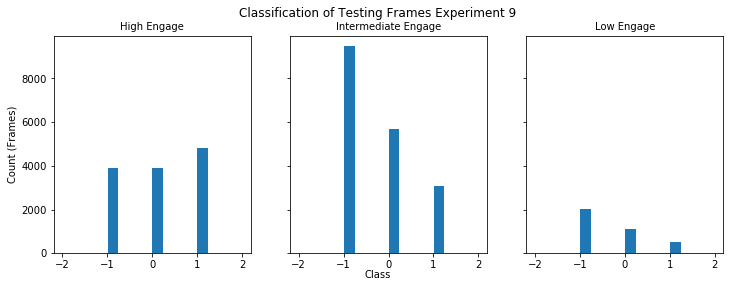

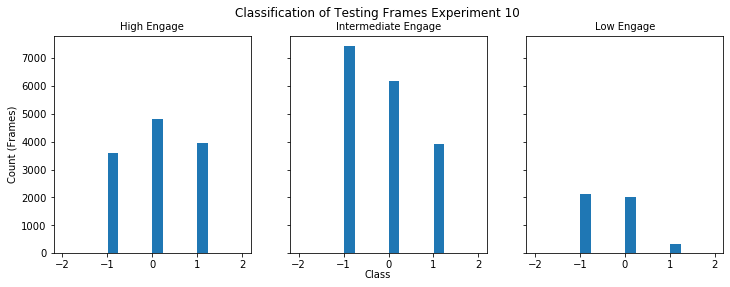

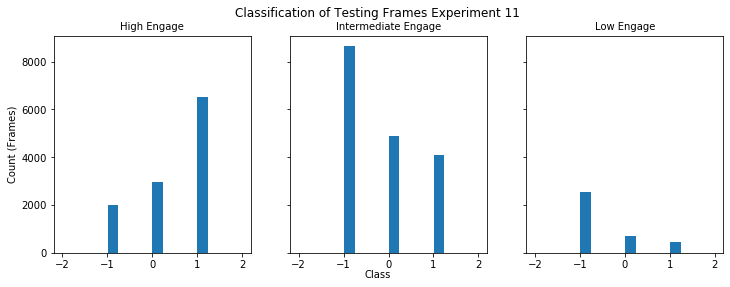

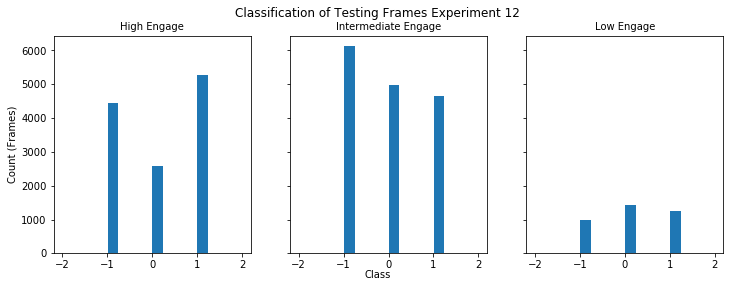

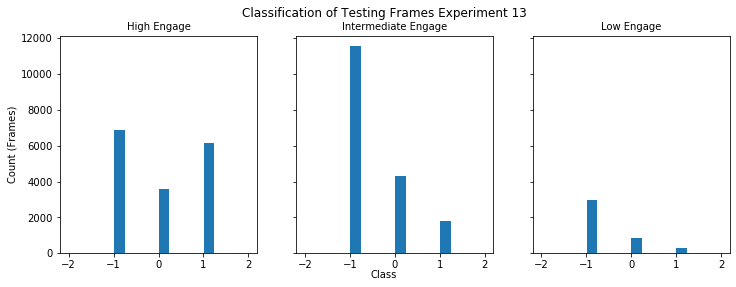

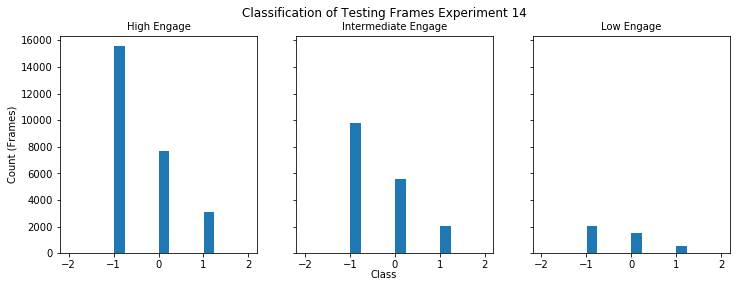

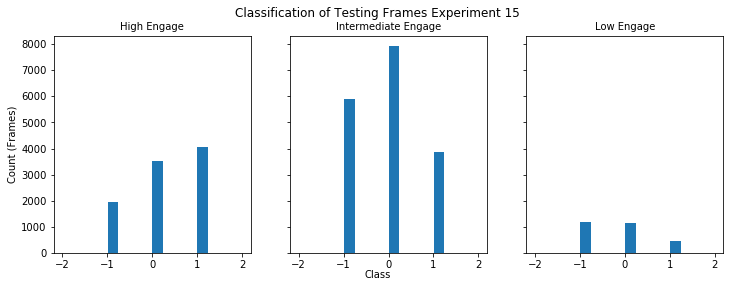

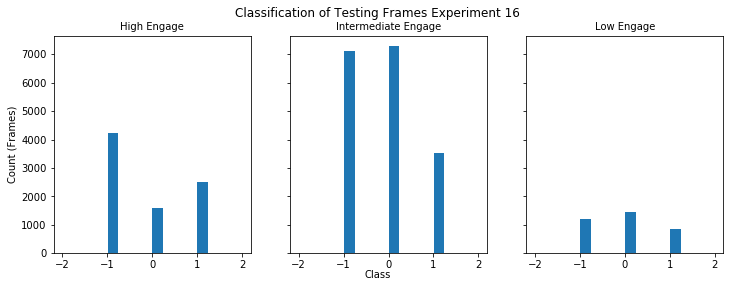

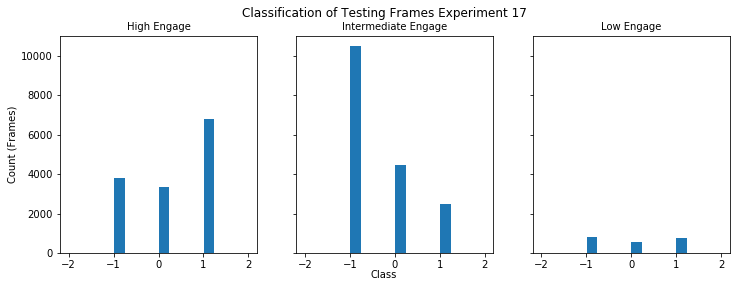

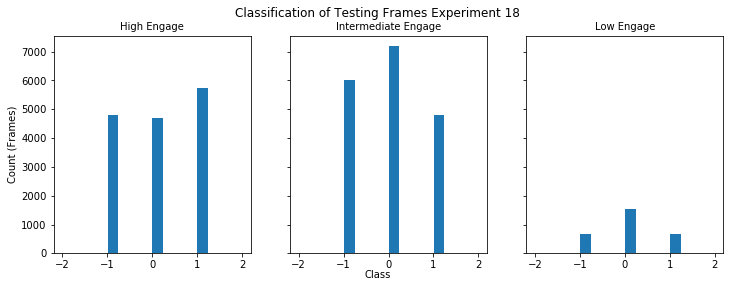

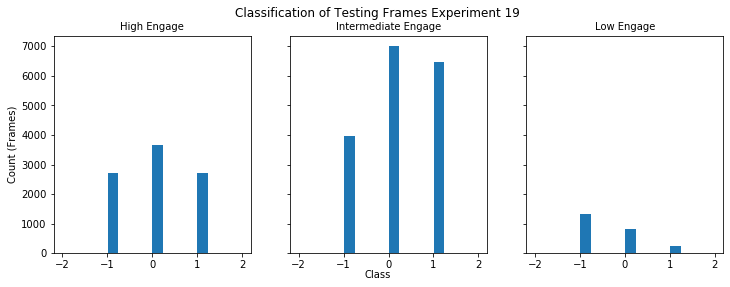

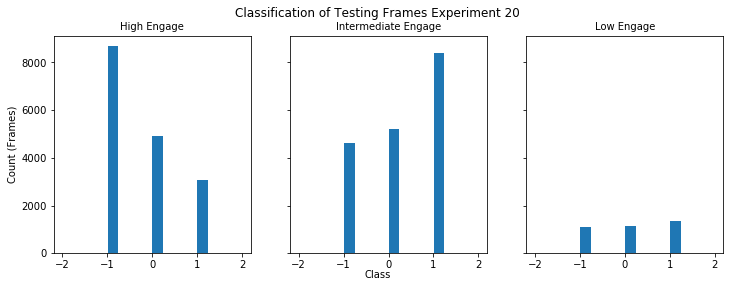

In [7]:
#collect data from testing clips across all experiments
higheng_testing=classifieddata.loc['output_goal_test000': 'output_goal_test019'] 
mideng_testing=classifieddata.loc['output_aimless000': 'output_aimless049'] 
loweng_testing=classifieddata.loc['output_noplay_test000': 'output_noplay_test016'] 

for i in range(20): #for each experiment
    exp = higheng_testing[i::20] #collect all high engagement testing clips from 1 experiment    
    higheng=[]
    for r in range(len(exp)): #for each high engagement testing clip in this experiment
        b=np.hstack(exp.iloc[r]['output']) #stack the data
        b_filt=spsig.medfilt(b,9) #apply a median filter
        higheng=np.concatenate((higheng, b_filt)) #save result to list
        
    #Repeat for intermediate engagement testing clips
    exp = mideng_testing[i::20]   
    mideng=[]
    for r in range(len(exp)): 
        b=np.hstack(exp.iloc[r]['output']) 
        b_filt=spsig.medfilt(b,9) 
        mideng=np.concatenate((mideng, b_filt)) 
        
    #Repeat for low engagement testing clips
    exp = loweng_testing[i::20]   
    loweng=[]
    for r in range(len(exp)): 
        b=np.hstack(exp.iloc[r]['output']) 
        b_filt=spsig.medfilt(b,9) 
        loweng=np.concatenate((loweng, b_filt)) 
        
    #Plot histograms
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
    ax1.hist(higheng, bins=bins, rwidth=0.95)
    ax1.set_title('High Engage', fontsize=10)
    ax1.set_ylabel('Count (Frames)', fontsize=10)
    ax1.set_xticks([-2,-1,0,1,2])
    ax2.hist(mideng, bins=bins, rwidth=0.95)
    ax2.set_title('Intermediate Engage', fontsize=10)
    ax2.set_xticks([-2,-1,0,1,2])
    ax3.hist(loweng, bins=bins, rwidth=0.95)
    ax3.set_title('Low Engage', fontsize=10)
    ax3.set_xticks([-2,-1,0,1,2])

    fig.suptitle('Classification of Testing Frames Experiment %d' % int(i+1), fontsize=12)
    fig.text(0.5, 0.04, 'Class', ha='center', fontsize=10)

Plot histograms of classification values for testing clips across all 20 experiments.

Text(0.5, 0.04, 'Class')

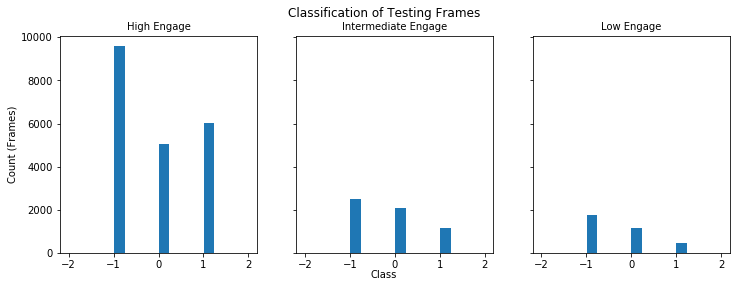

In [8]:
higheng=[]
for r in range(len(exp)): #for each high engagement testing clip
    b=np.hstack(np.hstack(higheng_testing.iloc[r]['output'])) #stack the data
    b_filt=spsig.medfilt(b,9) #apply a median filter
    higheng=np.concatenate((higheng, b_filt)) #save result to list

#Repeat for intermediate engagement testing clips
mideng=[]
for r in range(len(exp)): 
    b=np.hstack(np.hstack(mideng_testing.iloc[r]['output'])) 
    b_filt=spsig.medfilt(b,9) 
    mideng=np.concatenate((mideng, b_filt)) 

#Repeat for low engagement testing clips
loweng=[]
for r in range(len(exp)): 
    b=np.hstack(np.hstack(loweng_testing.iloc[r]['output'])) 
    b_filt=spsig.medfilt(b,9) 
    loweng=np.concatenate((loweng, b_filt)) 

#Plot histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax1.hist(higheng, bins=bins, rwidth=0.95)
ax1.set_title('High Engage', fontsize=10)
ax1.set_ylabel('Count (Frames)', fontsize=10)
ax1.set_xticks([-2,-1,0,1,2])
ax2.hist(mideng, bins=bins, rwidth=0.95)
ax2.set_title('Intermediate Engage', fontsize=10)
ax2.set_xticks([-2,-1,0,1,2])
ax3.hist(loweng, bins=bins, rwidth=0.95)
ax3.set_title('Low Engage', fontsize=10)
ax3.set_xticks([-2,-1,0,1,2])

fig.suptitle('Classification of Testing Frames', fontsize=12)
fig.text(0.5, 0.04, 'Class', ha='center', fontsize=10)

# Classification Average
Classify the average output for each clip

Plot histogram of classification value for average value of high and low engage training patterns across all 20 experiments (1 average per pattern per experiment).

Text(0.5, 1.0, 'Low Engage')

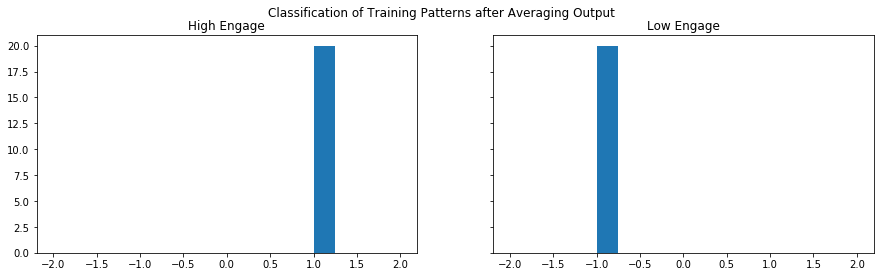

In [9]:
higheng_mean=rawdata.loc['output_goal_train']
loweng_mean=rawdata.loc['output_noplay_train']

for r in range(20):
    b=np.hstack([higheng_mean.iloc[r]['output']])
    b_mean = np.mean(b)
    if np.isclose(b_mean, 1, atol=0.6):
        higheng_mean.iloc[r]['output'] = 1
    elif np.isclose(b_mean, 0, atol=0.3):
        higheng_mean.iloc[r]['output'] = 0  
    else:
        higheng_mean.iloc[r]['output'] = -1
    b=np.hstack([loweng_mean.iloc[r]['output']])
    b_mean = np.mean(b)
    if np.isclose(b_mean, 1, atol=0.6):
        loweng_mean.iloc[r]['output'] = 1
    elif np.isclose(b_mean, 0, atol=0.3):
        loweng_mean.iloc[r]['output'] = 0  
    else:
        loweng_mean.iloc[r]['output'] = -1
        
bins=np.arange(-2, 2 + 0.25, 0.25)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
f.suptitle('Classification of Training Patterns after Averaging Output')
ax1.hist(higheng_mean['output'], bins=bins, rwidth=0.95)
ax1.set_title('High Engage')
ax2.hist(loweng_mean['output'], bins=bins, rwidth=0.95)
ax2.set_title('Low Engage')

Classification of average output for each testing clip in each experiment.

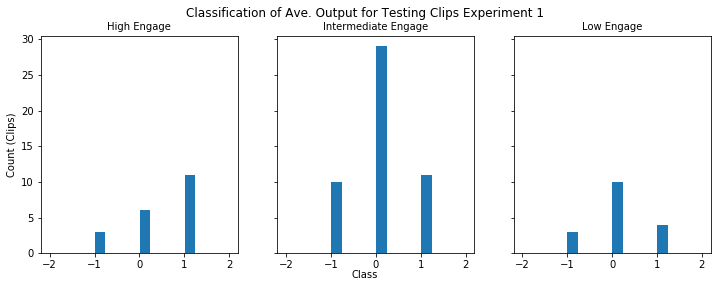

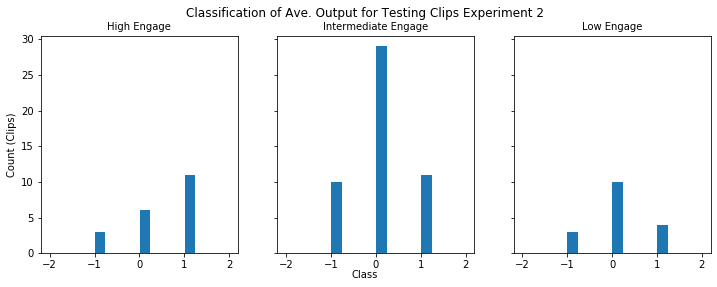

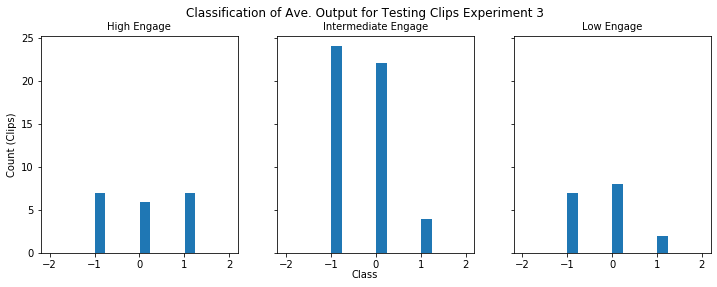

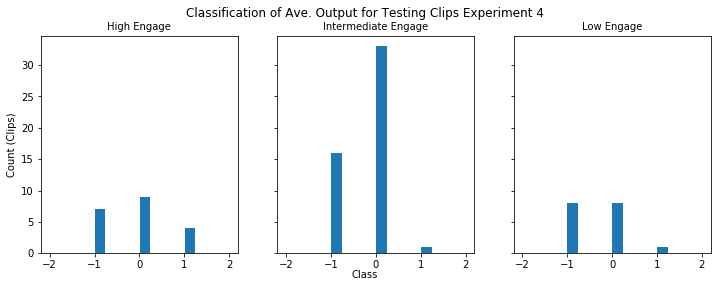

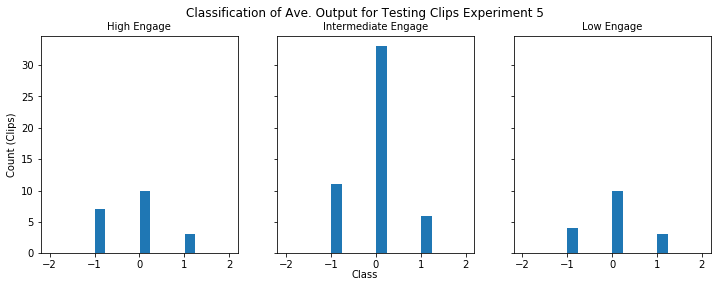

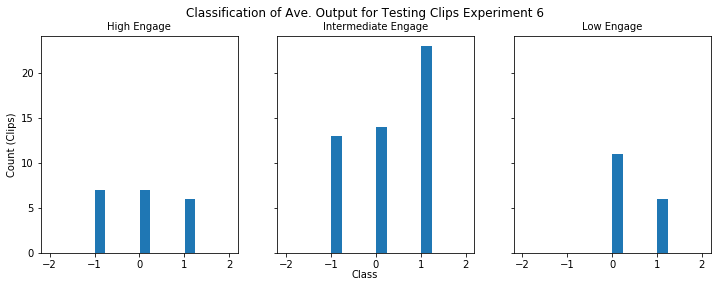

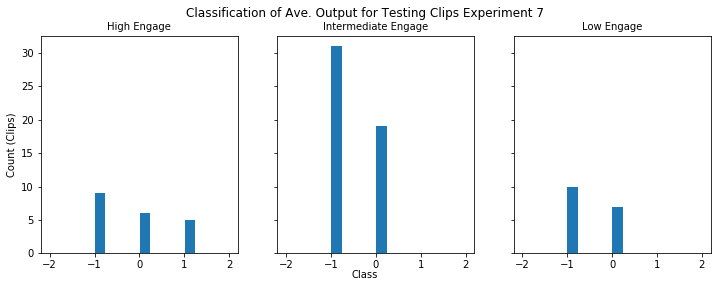

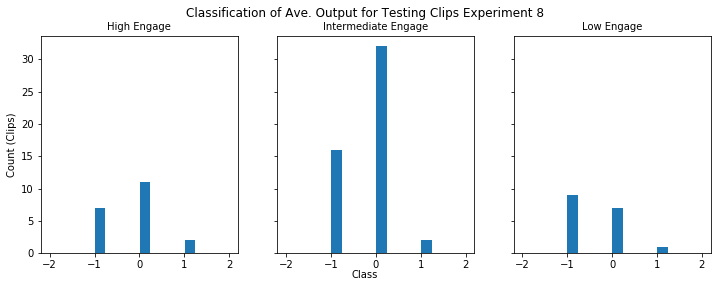

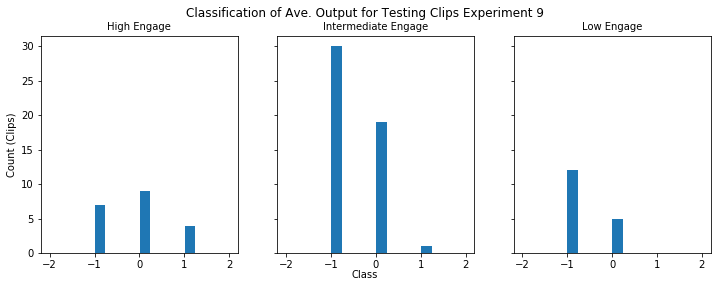

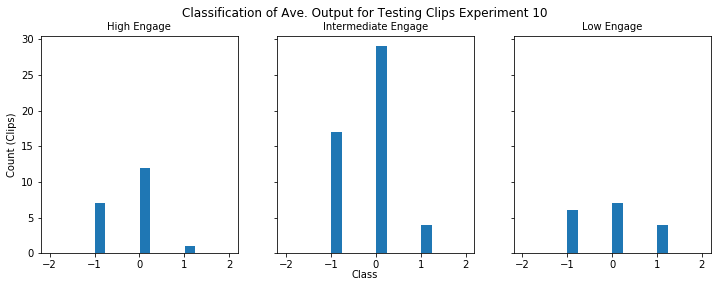

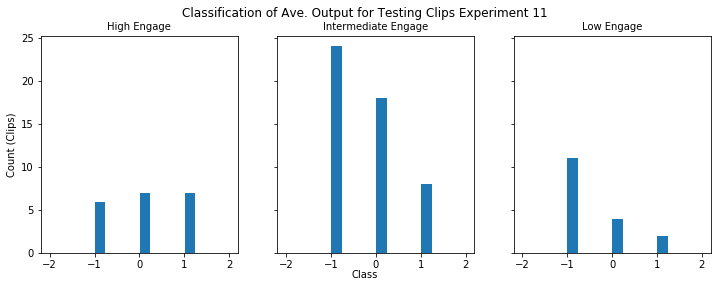

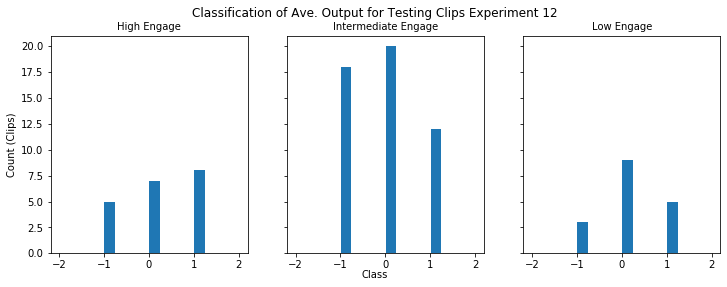

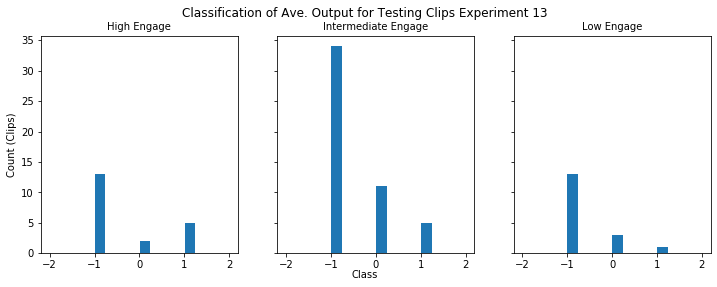

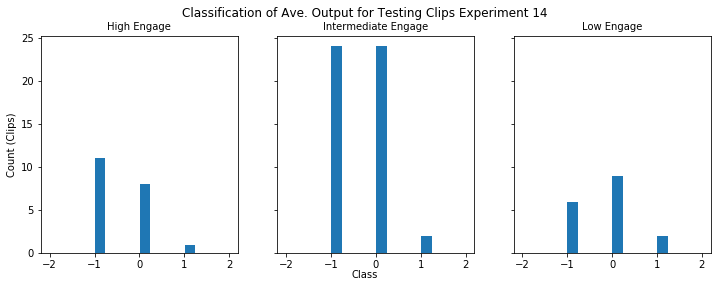

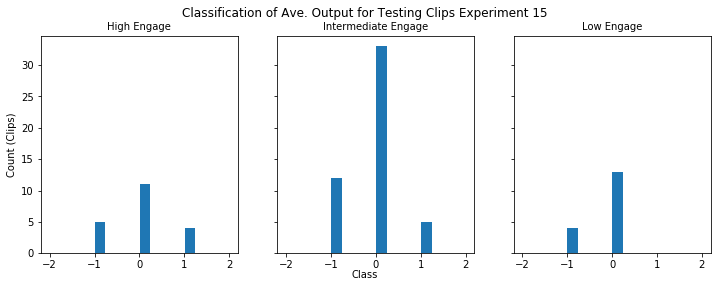

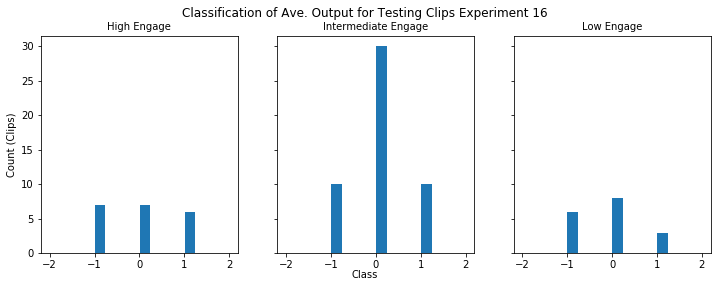

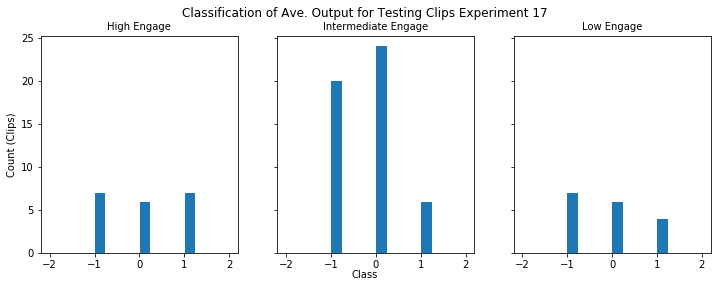

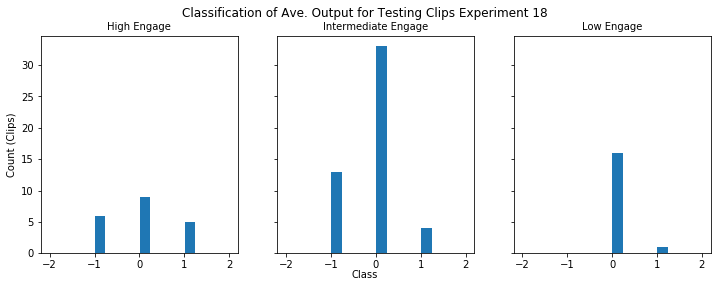

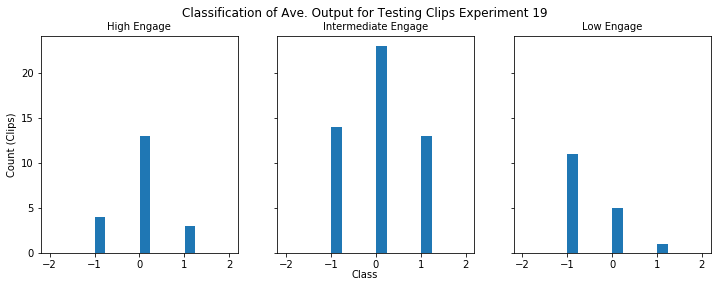

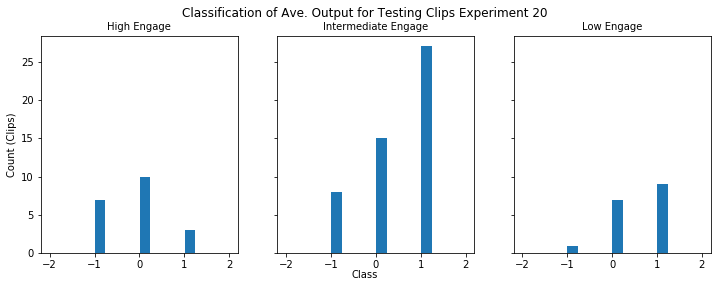

In [10]:
#collect data from testing clips across all experiments
higheng_testing=rawdata.loc['output_goal_test000': 'output_goal_test019'] 
mideng_testing=rawdata.loc['output_aimless000': 'output_aimless049'] 
loweng_testing=rawdata.loc['output_noplay_test000': 'output_noplay_test016'] 

for i in range(20): #for each experiment
    higheng=[]
    mideng=[]
    loweng=[]
    exp = higheng_testing[i::20] #collect all high engagement testing clips from 1 experiment    
    for r in range(len(exp)): #for each high engagement testing clip in this experiment
        #get mean output
        b=np.hstack([exp.iloc[r]['output']])
        b_mean = np.mean(b)
        #classify mean output
        if np.isclose(b_mean, 1, atol=0.6):
            higheng.append(1)
        elif np.isclose(b_mean, 0, atol=0.3):
            higheng.append(0)
        else:
            higheng.append(-1)
    
    #Repeat for intermediate engagement testing clips
    exp = mideng_testing[i::20]  
    for r in range(len(exp)): 
        b=np.hstack([exp.iloc[r]['output']])
        b_mean = np.mean(b)
        if np.isclose(b_mean, 1, atol=0.6):
            mideng.append(1)
        elif np.isclose(b_mean, 0, atol=0.3):
            mideng.append(0)
        else:
            mideng.append(-1)
        
    #Repeat for low engagement testing clips
    exp = loweng_testing[i::20] 
    for r in range(len(exp)): 
        b=np.hstack([exp.iloc[r]['output']])
        b_mean = np.mean(b)
        if np.isclose(b_mean, 1, atol=0.6):
            loweng.append(1)
        elif np.isclose(b_mean, 0, atol=0.3):
            loweng.append(0)
        else:
            loweng.append(-1)
        
    #Plot histograms
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
    ax1.hist(higheng, bins=bins, rwidth=0.95)
    ax1.set_title('High Engage', fontsize=10)
    ax1.set_ylabel('Count (Clips)', fontsize=10)
    ax1.set_xticks([-2,-1,0,1,2])
    ax2.hist(mideng, bins=bins, rwidth=0.95)
    ax2.set_title('Intermediate Engage', fontsize=10)
    ax2.set_xticks([-2,-1,0,1,2])
    ax3.hist(loweng, bins=bins, rwidth=0.95)
    ax3.set_title('Low Engage', fontsize=10)
    ax3.set_xticks([-2,-1,0,1,2])

    fig.suptitle('Classification of Ave. Output for Testing Clips Experiment %d' % int(i+1), fontsize=12)
    fig.text(0.5, 0.04, 'Class', ha='center', fontsize=10)

Plot histograms of classification of average output for each testing clip across all 20 experiments.

Text(0.5, 0.04, 'Class')

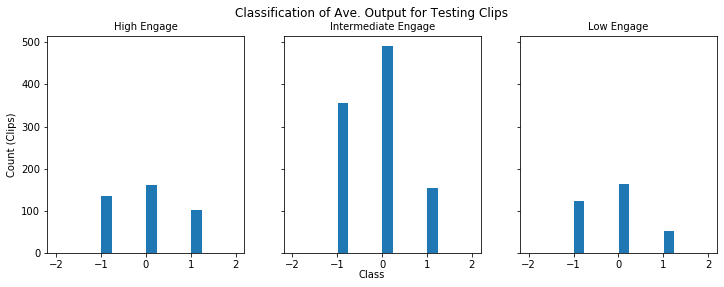

In [12]:
#collect data from testing clips across all experiments
higheng_testing=rawdata.loc['output_goal_test000': 'output_goal_test019'] 
mideng_testing=rawdata.loc['output_aimless000': 'output_aimless049'] 
loweng_testing=rawdata.loc['output_noplay_test000': 'output_noplay_test016'] 

higheng=[]
mideng=[]
loweng=[]

for i in range(20): #for each experiment
    exp = higheng_testing[i::20] #collect all high engagement testing clips from 1 experiment    
    for r in range(len(exp)): #for each high engagement testing clip in this experiment
        #get mean output
        b=np.hstack([exp.iloc[r]['output']])
        b_mean = np.mean(b)
        #classify mean output
        if np.isclose(b_mean, 1, atol=0.6):
            higheng.append(1)
        elif np.isclose(b_mean, 0, atol=0.3):
            higheng.append(0)
        else:
            higheng.append(-1)
    
    #Repeat for intermediate engagement testing clips
    exp = mideng_testing[i::20]  
    for r in range(len(exp)): 
        b=np.hstack([exp.iloc[r]['output']])
        b_mean = np.mean(b)
        if np.isclose(b_mean, 1, atol=0.6):
            mideng.append(1)
        elif np.isclose(b_mean, 0, atol=0.3):
            mideng.append(0)
        else:
            mideng.append(-1)
        
    #Repeat for low engagement testing clips
    exp = loweng_testing[i::20] 
    for r in range(len(exp)): 
        b=np.hstack([exp.iloc[r]['output']])
        b_mean = np.mean(b)
        if np.isclose(b_mean, 1, atol=0.6):
            loweng.append(1)
        elif np.isclose(b_mean, 0, atol=0.3):
            loweng.append(0)
        else:
            loweng.append(-1)
        
#Plot histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax1.hist(higheng, bins=bins, rwidth=0.95)
ax1.set_title('High Engage', fontsize=10)
ax1.set_ylabel('Count (Clips)', fontsize=10)
ax1.set_xticks([-2,-1,0,1,2])
ax2.hist(mideng, bins=bins, rwidth=0.95)
ax2.set_title('Intermediate Engage', fontsize=10)
ax2.set_xticks([-2,-1,0,1,2])
ax3.hist(loweng, bins=bins, rwidth=0.95)
ax3.set_title('Low Engage', fontsize=10)
ax3.set_xticks([-2,-1,0,1,2])

fig.suptitle('Classification of Ave. Output for Testing Clips', fontsize=12)
fig.text(0.5, 0.04, 'Class', ha='center', fontsize=10)